In [70]:
import numpy, pandas, glob, random, seaborn, re, matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from matplotlib.lines import Line2D
from matplotlib import colors
import sklearn.linear_model
from sklearn.model_selection import KFold
import statsmodels
import statsmodels.api as sm
from statsmodels.stats.api import anova_lm
from statsmodels.formula.api import ols
from statsmodels.stats import multitest
from pyplink import PyPlink
import rpy2.robjects as R
from utils import *
matplotlib.rcParams['figure.dpi'] = 300

In [71]:
# define cohort and taxonomy level
cohort = 'both'
taxa_level = 'genus'
bmi_or_not = 'bmi'
classification = 'silva'
classification_method = classification + '_classification'

# load phenotype 

In [72]:
# load pheno
micro_metab_unadj = pandas.read_csv('./joint_pheno/{0}_{1}_{2}_micro_metab_unadj.pheno'.format(cohort, taxa_level, classification), index_col = [0,1])
micro_metab_covar = pandas.read_csv('./joint_pheno/{0}_{1}_{2}_micro_metab_unadj.covar'.format(cohort, taxa_level, classification), index_col = [0,1])
pheno_covar_merged_full = micro_metab_unadj.join(micro_metab_covar)
pheno_covar_merged_full.index = pheno_covar_merged_full.index.droplevel(0)
pheno_covar_merged_full.columns = [rename_numerical_id(col) for col in pheno_covar_merged_full.columns]

# define covariates
q_covar = ['age','age_sq','sex_age','sex_age_sq','PC1','PC2','PC3','PC4','PC5', 'bmi']
c_covar = ['sex','batch']
rename_c_covar = ['C({0})'.format(covar) for covar in c_covar]
covariates = q_covar + c_covar

form_covar = ['scale(age)', 'I(scale(age)**2)', 'PC1','PC2','PC3','PC4','PC5', 'bmi']
int_covar = ['scale(age)*C(sex)', 'I(scale(age)**2)*C(sex)']
form_covar = form_covar + rename_c_covar + int_covar

# load association
micro_metab_assoc = pandas.read_csv('./assoc_results/{0}_sig_metab_{1}_{2}_classification_lasso.csv'.format(cohort, taxa_level, classification))
micro_metab_assoc['metabolite_id'] = [rename_numerical_id(identifier) for identifier in micro_metab_assoc['metabolite_id']]
micro_metab_assoc['tax_id'] = [rename_numerical_id(identifier) for identifier in micro_metab_assoc['tax_id']]
sig_metabolite = micro_metab_assoc['metabolite_id'].unique()
print(len(sig_metabolite))

# get metadata
metabolite_metadata = pandas.read_csv('./input_pheno/all_metab_11192021.pheno.metadata', sep = '\t', dtype=str)
metabolite_metadata = metabolite_metadata.groupby('metabolite_id').first()[['metabolite', 'sub_pathway', 'super_pathway']]
metabolite_metadata.index = [rename_numerical_id(identifier) for identifier in metabolite_metadata.index]
metabolite_metadata_dict = metabolite_metadata['metabolite'].to_dict()
metabolite_super_pathway_dict = metabolite_metadata['super_pathway'].to_dict()

taxa_metadata = pandas.read_csv('./joint_pheno/{0}_{1}.metadata'.format(taxa_level, classification_method), dtype=str, sep = '\t')
taxa_metadata = taxa_metadata.set_index('tax_id')
taxa_metadata.index = [rename_numerical_id(identifier) for identifier in taxa_metadata.index]
genus_metadata_dict = taxa_metadata['taxonomy'].str.split(';').str.get(-1).to_dict()

176


# get genotype

In [73]:
genotype = PyPlink('./input_bed/all_chr/all_genomes_09112019_all_chr')
# genotype = PyPlink('/homedir/notebooks-cheng/mgwas/data/snp_query_03182019/final_merged/bed_files/all_chr/merged_metabolome_inds_biallelic_variants_all_chr')
sample_ids = genotype.get_fam().iid.values

In [74]:
snp_list = 'validate_gwas/clumped_variants/metab/fastgwa/clumped_10perc_second_pass_list.txt'
sig_metab_assoc = pandas.read_csv(snp_list, sep = '\t', header = None)
sig_metab_assoc.columns = ['rsid', 'Phenotype']

# subset to phenotypes that have microbiome associations
sig_metab_assoc = sig_metab_assoc[sig_metab_assoc['Phenotype'].isin(micro_metab_assoc['metabolite_id'].values)]
sig_metab_assoc = sig_metab_assoc[~sig_metab_assoc['Phenotype'].str.contains('X99')]
print(len(sig_metab_assoc['Phenotype'].unique()))

176


# run GxE

In [75]:
from multiprocessing import Pool
from rich.progress import track
from itertools import product
from os import path

pheno_covar_merged = pheno_covar_merged_full.copy()

gxe_results = []
rev_rsid_map = {}
microbes = list(micro_metab_assoc['tax_id'].unique())

# Assemble a table of all SNPs
metabs = list(sig_metab_assoc['Phenotype'].unique())
rsids = sig_metab_assoc['rsid'].unique()
renamed_rsids = pandas.Series({i: i.split(';')[0] for i in rsids})
dfs = [pandas.DataFrame(genotype.get_geno_marker(rsid), index = sample_ids, columns = [rsid]) for rsid in rsids]
geno = pandas.concat(dfs, axis=1)
geno.rename(columns = renamed_rsids, inplace=True)
geno_pheno_covar = pheno_covar_merged[metabs + microbes + covariates].join(geno, how = 'outer')

def betas(args):
    """Get the gene environment interaction coefficients."""
    metab, microbe = args
    rsids = renamed_rsids[sig_metab_assoc.loc[sig_metab_assoc['Phenotype'] == metab, 'rsid']].tolist()
    # print(metab, metabolite_metadata_dict[metab], f'# snps: {len(rsids)}', f'# bugs: {len(microbes)}')

    df = geno_pheno_covar[[metab] + [microbe] + rsids + covariates].dropna()

    gxes = []
    
    result = pandas.DataFrame(
        index = [metab + ':' + microbe + ':' + i for i in rsids],
        columns = ['metabolite_id','tax_id','rsid', 'genetics_beta', 'gxe_beta','pval', 
                   'baseline_rsq', 'without_microbe_rsq', 'gxe_rsq', 'n_alt_0', 'n_alt_1', 'n_alt_2']
    )
    for rsid in rsids:

        try:
            assert (df.groupby(rsid).count() > 30).all().all()
            n_alt_count = df.groupby(rsid).count()
            n_alt_0 = n_alt_count.loc[0][0]
            n_alt_1 = n_alt_count.loc[1][0]
            n_alt_2 = n_alt_count.loc[2][0]
        except:
            continue 
        gxe_term = rsid + ':' + microbe
        no_microbe_formula = metab + ' ~ ' + ' + '.join(form_covar + [rsid])    
        no_gxe_formula = metab + ' ~ ' + ' + '.join(form_covar + [rsid] + [microbe])
        gxe_formula = metab + ' ~ ' + ' + '.join(form_covar + [rsid] + [microbe] + [gxe_term])
        
        no_int_out = ols(no_gxe_formula, df).fit()
        baseline_rsq = no_int_out.rsquared
        
        no_microbe_rsq = ols(no_microbe_formula, df).fit().rsquared
        
        int_out = ols(gxe_formula, df).fit()
        int_rsq = int_out.rsquared
        gxe_beta = int_out.params.loc[gxe_term]
        genetics_beta = int_out.params.loc[rsid]
        gxe_pval = int_out.pvalues.loc[gxe_term]
        
        result.loc[metab + ':' + microbe + ':' + rsid] = [
            metab, microbe, rsid, genetics_beta, gxe_beta, gxe_pval, baseline_rsq, no_microbe_rsq, 
            int_rsq, n_alt_0, n_alt_1, n_alt_2
        ]
            
    return result

if not path.exists("gxe_results.csv"):
    with Pool(8) as pool:
        args = [(met, mic) for met in metabs for mic in microbes]
        it = track(pool.imap_unordered(betas, args), total=len(args), description='Fitting models')
        results = pandas.concat(list(it))
    fdr_pass, adj_pval, sidack, bonff = statsmodels.stats.multitest.multipletests(results['pval'].values, method='fdr_bh', alpha=0.05)
    results['pass_fdr'] = adj_pval < 0.05
    results['adj_pval'] = adj_pval
    results.to_csv("gxe_results.csv", index=False)
else:
    results = pd.read_csv("gxe_results.csv")


In [76]:
gxe_fold_results_annotated

metabolite_id                                   tax_id        rsid  \
0        X100000007  X909b8848be3595a45c5a70038116808f_genus   rs1171617   
1        X100000007  X850b64752c573c8785e7997aa9daf0d6_genus   rs1171617   
2        X100000007                                alpha_div   rs1171617   
3        X100000007  X911b4f6c8ce81573e33a0dd2c12e330f_genus   rs1171617   
4        X100000007  X57e80f5c1e5d43e276db32838721af29_genus   rs1171617   
...             ...                                      ...         ...   
16900           X98  X7227d85edd7639fcda716554c15413c5_genus  rs61825638   
16901           X98  X7bd9fff750bf0f266ae83dd980377bf2_genus  rs61825638   
16902           X98  X6306fe4b170e2c98e7dee940caa2897c_genus  rs61825638   
16903           X98   d60782d0fee4ea32bde1ee988c152e2e_genus  rs61825638   
16904           X98   e599a99248da92310cb872213e377cda_genus  rs61825638   

       genetics_beta  gxe_beta      pval  baseline_rsq  without_microbe_rsq  \
0           0.056330 -0.001235  0.796451      0.194550             0.192878   
1           0.055750  0.003881  0.278454      0.192701             0.192698   
2           0.056331 -0.023056  0.223154      0.194181             0.193954   
3           0.056478  0.004945  0.134129      0.193440             0.192698   
4           0.056230 -0.008195  0.034698      0.193234             0.192698   
...              ...       ...       ...           ...                  ...   
16900       0.123290 -0.006145  0.366399      0.215254             0.214898   
16901       0.124035  0.008425  0.082686      0.215604             0.214898   
16902       0.121946 -0.011975  0.354479      0.208405             0.207489   
16903       0.122405  0.006995  0.471308      0.214965             0.214949   
16904       0.126213 -0.033128  0.039621      0.219714             0.219207   

        gxe_rsq  n_alt_0  ...  Species  sequence  \
0      0.194600     56.0  ...      NaN       NaN   
1      0.193570     56.0  ...      NaN       NaN   
2      0.195288     56.0  ...      NaN       NaN   
3      0.195100     56.0  ...      NaN       NaN   
4      0.196530     56.0  ...      NaN       NaN   
...         ...      ...  ...      ...       ...   
16900  0.215842    658.0  ...      NaN       NaN   
16901  0.217771    658.0  ...      NaN       NaN   
16902  0.209046    639.0  ...      NaN       NaN   
16903  0.215339    657.0  ...      NaN       NaN   
16904  0.222829    642.0  ...      NaN       NaN   

                                                taxonomy  \
0      k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...   
1      k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...   
2                                Shannon alpha diversity   
3      k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...   
4      k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...   
...                                                  ...   
16900  k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...   
16901  k__Bacteria;p__Firmicutes;c__Negativicutes;o__...   
16902  k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...   
16903  k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...   
16904  k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...   

                                 genus                 family         snp  \
0                           g__UBA1819     f__Ruminococcaceae   rs1171617   
1      g__Lachnospiraceae_ND3007_group     f__Lachnospiraceae   rs1171617   
2              Shannon alpha diversity                    NaN   rs1171617   
3           g__Lachnospiraceae_UCG-001     f__Lachnospiraceae   rs1171617   
4                    g__Marvinbryantia     f__Lachnospiraceae   rs1171617   
...                                ...                    ...         ...   
16900                   g__Odoribacter      f__Marinifilaceae  rs61825638   
16901         g__Phascolarctobacterium  f__Acidaminococcaceae  rs61825638   
16902              g__Fusicatenibacter     f__Lachnospiraceae  rs61825638   
16903             g__Caproic

In [77]:
gxe_fold_results_df = results.copy().dropna()
gxe_fold_results_annotated = gxe_fold_results_df.merge(metabolite_metadata, left_on = 'metabolite_id', right_index = True, how = 'left')
gxe_fold_results_annotated = gxe_fold_results_annotated.merge(taxa_metadata, left_on = 'tax_id', right_index = True, how = 'left')
gxe_fold_results_annotated['genus'] = gxe_fold_results_annotated['taxonomy'].str.split(';').str.get(-1)
gxe_fold_results_annotated['family'] = gxe_fold_results_annotated['taxonomy'].str.split(';').str.get(-2)

genes = rsid2gene(gxe_fold_results_annotated.rsid.unique())
gxe_fold_results_annotated = gxe_fold_results_annotated.merge(genes, left_on = 'rsid', right_on="snp", how = 'left')

gxe_fold_results_annotated.head()

metabolite_id                                   tax_id       rsid  \
0    X100000007  X909b8848be3595a45c5a70038116808f_genus  rs1171617   
1    X100000007  X850b64752c573c8785e7997aa9daf0d6_genus  rs1171617   
2    X100000007                                alpha_div  rs1171617   
3    X100000007  X911b4f6c8ce81573e33a0dd2c12e330f_genus  rs1171617   
4    X100000007  X57e80f5c1e5d43e276db32838721af29_genus  rs1171617   

   genetics_beta  gxe_beta      pval  baseline_rsq  without_microbe_rsq  \
0       0.056330 -0.001235  0.796451      0.194550             0.192878   
1       0.055750  0.003881  0.278454      0.192701             0.192698   
2       0.056331 -0.023056  0.223154      0.194181             0.193954   
3       0.056478  0.004945  0.134129      0.193440             0.192698   
4       0.056230 -0.008195  0.034698      0.193234             0.192698   

    gxe_rsq  n_alt_0  ...  Species  sequence  \
0  0.194600     56.0  ...      NaN       NaN   
1  0.193570     56.0  ...      NaN       NaN   
2  0.195288     56.0  ...      NaN       NaN   
3  0.195100     56.0  ...      NaN       NaN   
4  0.196530     56.0  ...      NaN       NaN   

                                            taxonomy  \
0  k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...   
1  k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...   
2                            Shannon alpha diversity   
3  k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...   
4  k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...   

                             genus              family        snp    genes  \
0                       g__UBA1819  f__Ruminococcaceae  rs1171617  SLC16A9   
1  g__Lachnospiraceae_ND3007_group  f__Lachnospiraceae  rs1171617  SLC16A9   
2          Shannon alpha diversity                 NaN  rs1171617  SLC16A9   
3       g__Lachnospiraceae_UCG-001  f__Lachnospiraceae  rs1171617  SLC16A9   
4                g__Marvinbryantia  f__Lachnospiraceae  rs1171617  SLC16A9   

  clinical chromosome                                    function_class  
0                  10  genic_upstream_transcript_variant,intron_variant  
1                  10  genic_upstream_transcript_variant,intron_variant  
2                  10  genic_upstream_transcript_variant,intron_variant  
3                  10  genic_upstream_transcript_variant,intron_variant  
4                  10  genic_upstream_transcript_variant,intron_variant  

[5 rows x 33 columns]

In [78]:
sig_gxe_fold_results_annotated = gxe_fold_results_annotated[gxe_fold_results_annotated['pass_fdr'] == True]

In [79]:
min_count = 30
gxe_results_sig_abundant = sig_gxe_fold_results_annotated[(sig_gxe_fold_results_annotated['n_alt_0'] > min_count) & 
                                           (sig_gxe_fold_results_annotated['n_alt_1'] > min_count) & 
                                           (sig_gxe_fold_results_annotated['n_alt_2'] > min_count)]

In [80]:
gxe_results_sig_abundant["gxe_only_rsq"] = gxe_results_sig_abundant.gxe_rsq - gxe_results_sig_abundant.baseline_rsq
temp_gxe_interest = gxe_results_sig_abundant.sort_values('pval', ascending=True).drop_duplicates()
temp_gxe_interest = temp_gxe_interest.reset_index(drop = True)

/users/cdiener/miniconda3/envs/gxe2021/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-81-e65381be42b5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-81-e65381be42b5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

(-0.43350481957970677, 6.81437334882629e-11)


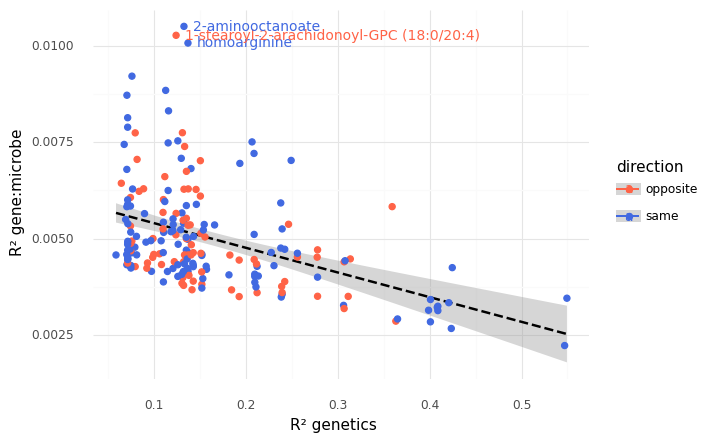

<ggplot: (8763948269216)>

In [81]:
from plotnine import *
import numpy as np
from scipy.stats import pearsonr

s = sig_gxe_fold_results_annotated

s.genetics_beta = s.genetics_beta.astype("float")
s.gxe_beta = s.gxe_beta.astype("float")
s.without_microbe_rsq = s.without_microbe_rsq.astype("float")
s.gxe_rsq = s.gxe_rsq.astype("float")
s.baseline_rsq = s.baseline_rsq.astype("float")
s["neg_log_pval"] = -np.log10(s.pval.astype("float"))
s["type"] = "opposite"
s.loc[s.gxe_beta * s.genetics_beta > 0, "type"] = "same"
s["gxe_only_rsq"] = s.gxe_rsq - s.baseline_rsq
s["genetics_rsq"] = s.without_microbe_rsq

pl = (
    ggplot(s, aes(y="gxe_only_rsq", x="genetics_rsq", color="type", group=1))
    + geom_smooth(linetype="dashed", method="lm")
    + geom_point(size=2)
    + theme_minimal()
    + geom_text(aes(label="metabolite"), data=s[s.gxe_only_rsq > 0.01], ha="left", nudge_x=0.01, size=10)
    + labs(x="R² genetics", y="R² gene:microbe", color="direction")
    + scale_color_manual(values=["tomato", "royalblue"])
)
print(pearsonr(s.gxe_only_rsq, s.genetics_rsq))
pl.save("figures/genetics_vs_gxe.pdf", width=6, height=5)
pl

In [82]:
s[s.tax_id == "alpha_div"]

metabolite_id     tax_id        rsid  genetics_beta  gxe_beta      pval  \
4254    X100001856  alpha_div   rs1077835       0.105161  0.147573  0.015634   
4407    X100001869  alpha_div    rs174547      -0.097314  0.044702  0.018999   
6455    X100004227  alpha_div  rs62149622      -0.131579  0.177241  0.018210   

      baseline_rsq  without_microbe_rsq   gxe_rsq  n_alt_0  ...  family  \
4254      0.075429             0.071495  0.080361    653.0  ...     NaN   
4407      0.254121             0.238970  0.257885    488.0  ...     NaN   
6455      0.134813             0.133252  0.139393    644.0  ...     NaN   

             snp                      genes  clinical chromosome  \
4254   rs1077835                       LIPC                   15   
4407    rs174547                      FADS1                   11   
6455  rs62149622  LOC105374802,LOC105374803                    2   

                                         function_class neg_log_pval  \
4254  intron_variant,upstream_transcript_variant,gen...     1.805924   
4407                                     intron_variant     1.721276   
6455  non_coding_transcript_variant,upstream_transcr...     1.739681   

          type gxe_only_rsq genetics_rsq  
4254      same     0.004932     0.071495  
4407  opposite     0.003764     0.238970  
6455  opposite     0.004580     0.133252  

[3 rows x 37 columns]

# plot

rs62317558 deoxycholic acid glucuronide g__Ruminococcaceae_UCG-014


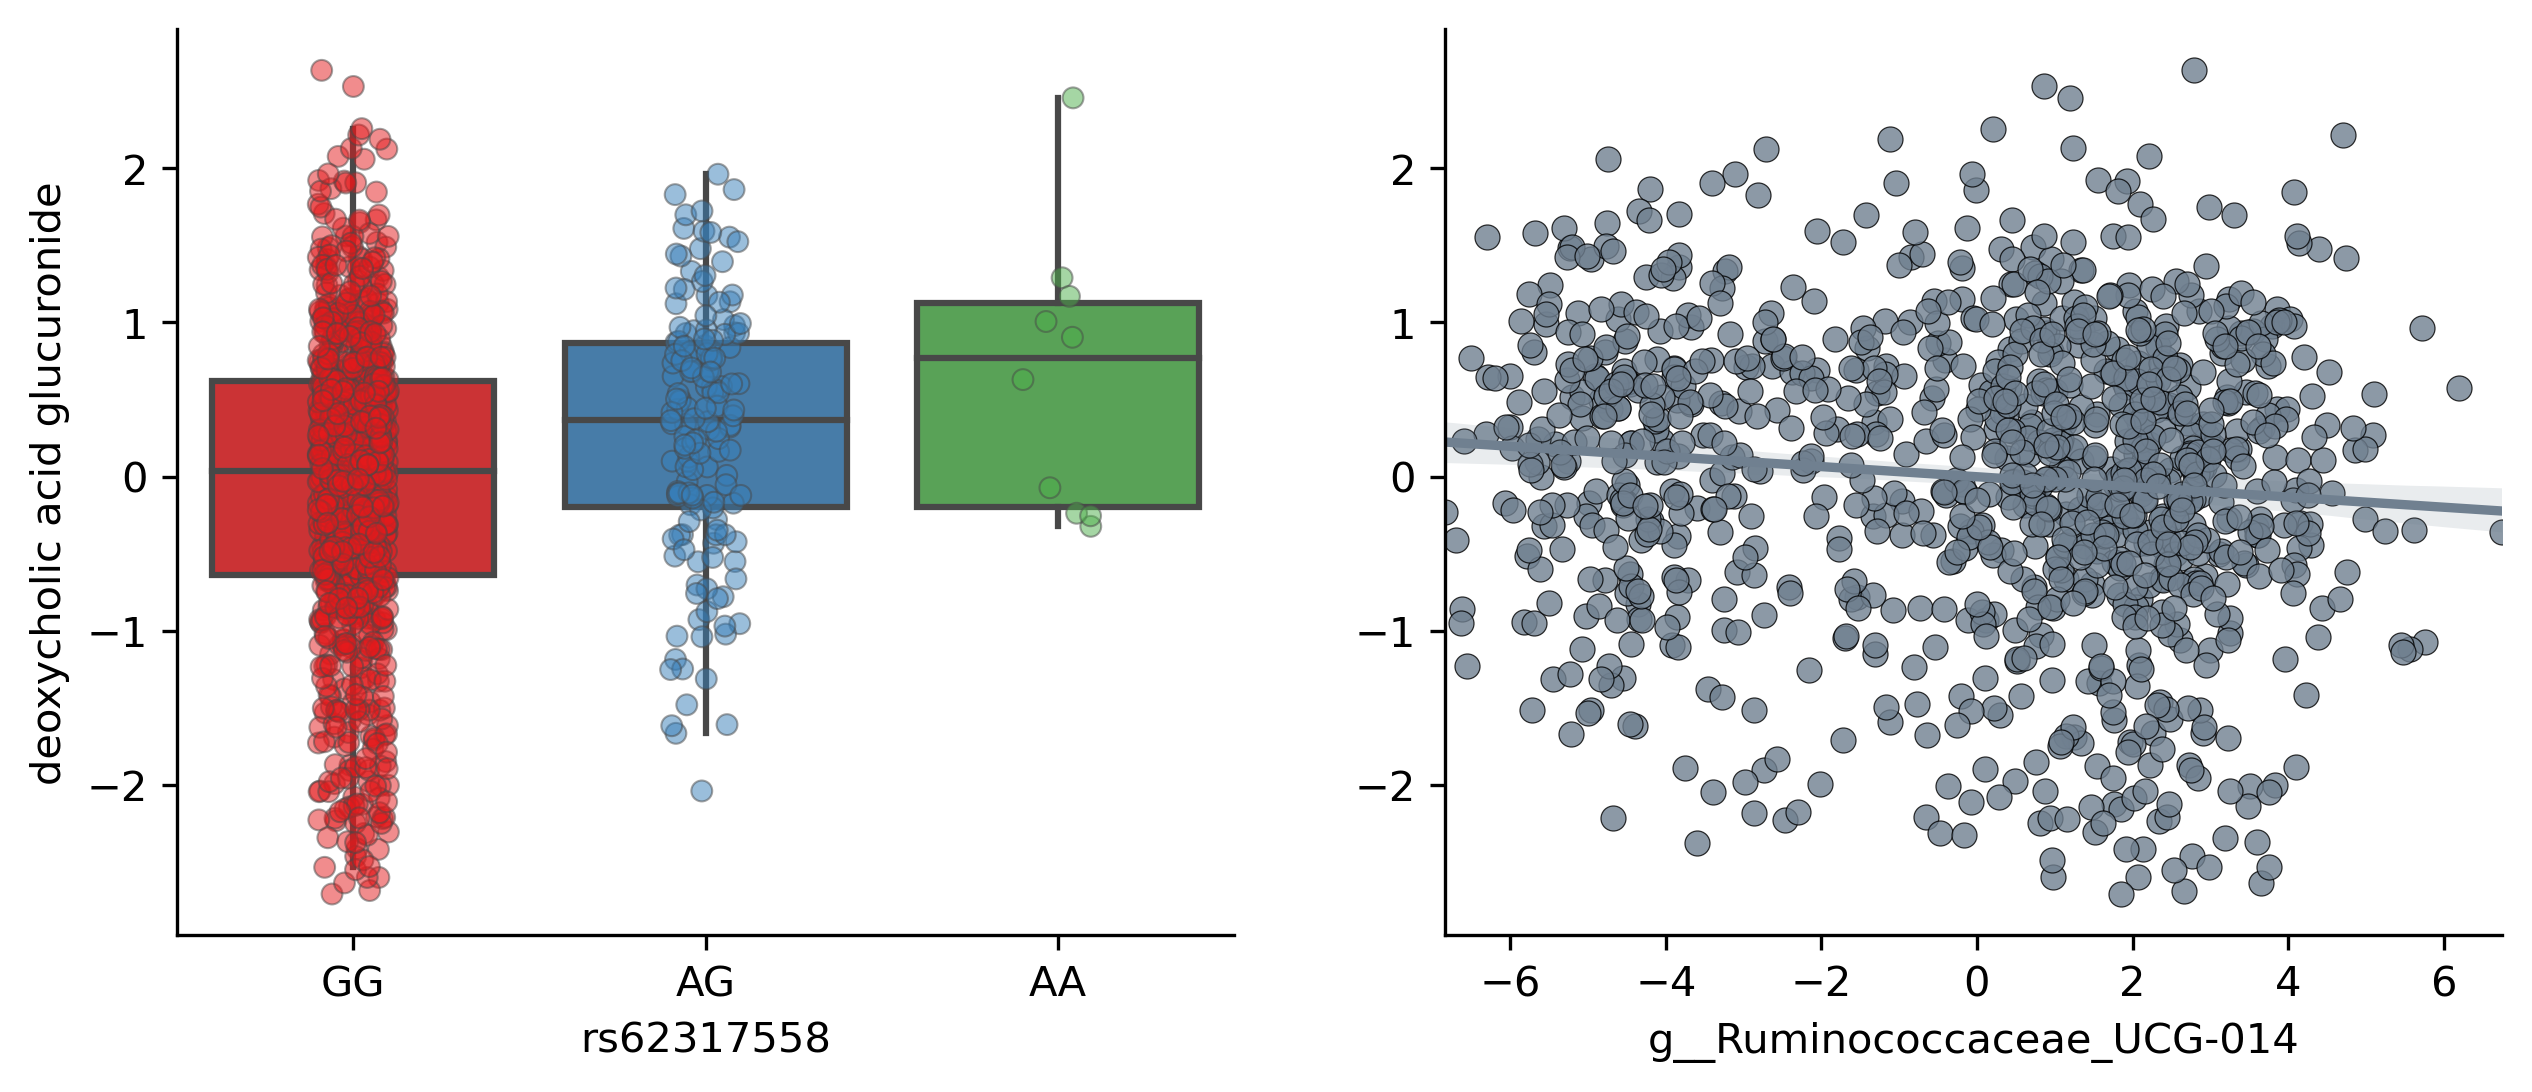

global rho=-0.103723, p=0.000651589
AA: rho=0.1983, p=0.582878
AG: rho=-0.184944, p=0.0216621
GG: rho=-0.0974396, p=0.0032066


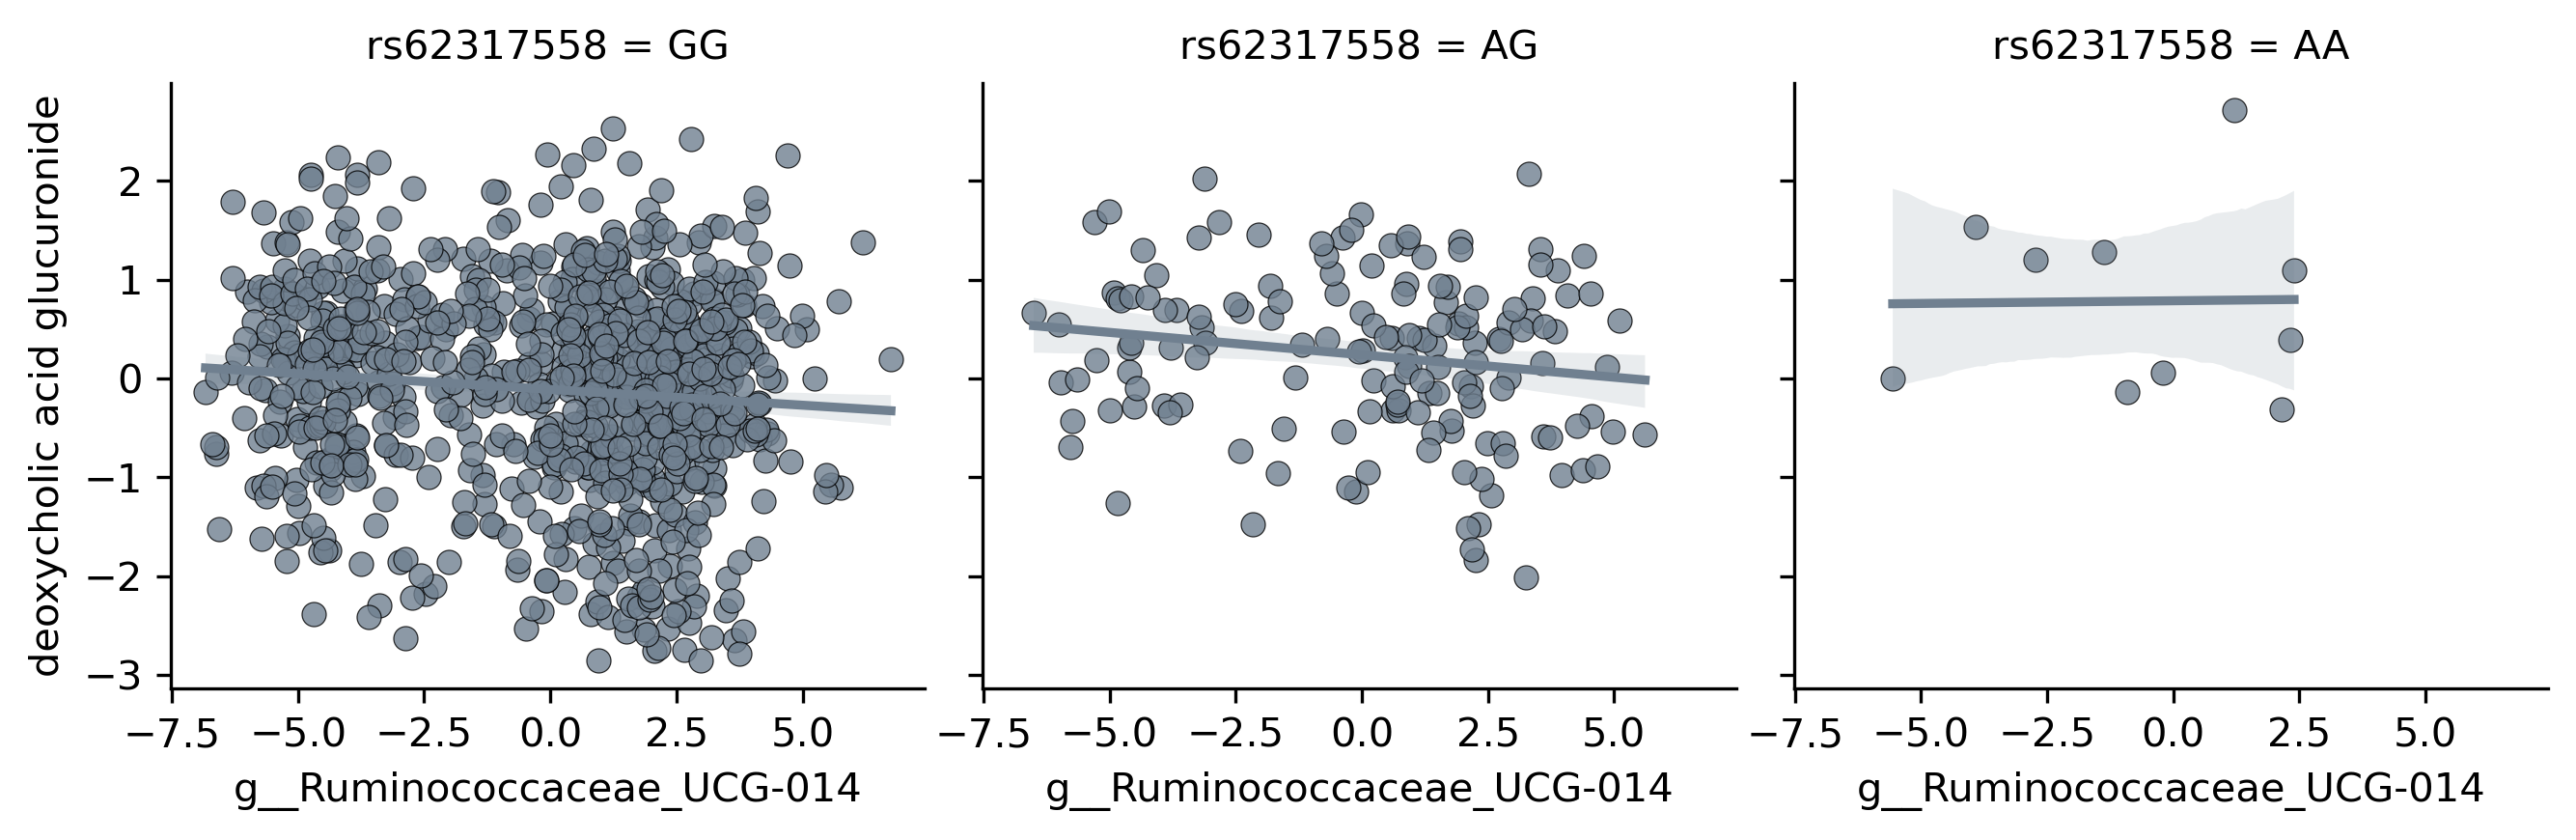

rs62317558 deoxycholic acid glucuronide g__Ruminococcaceae_UCG-014


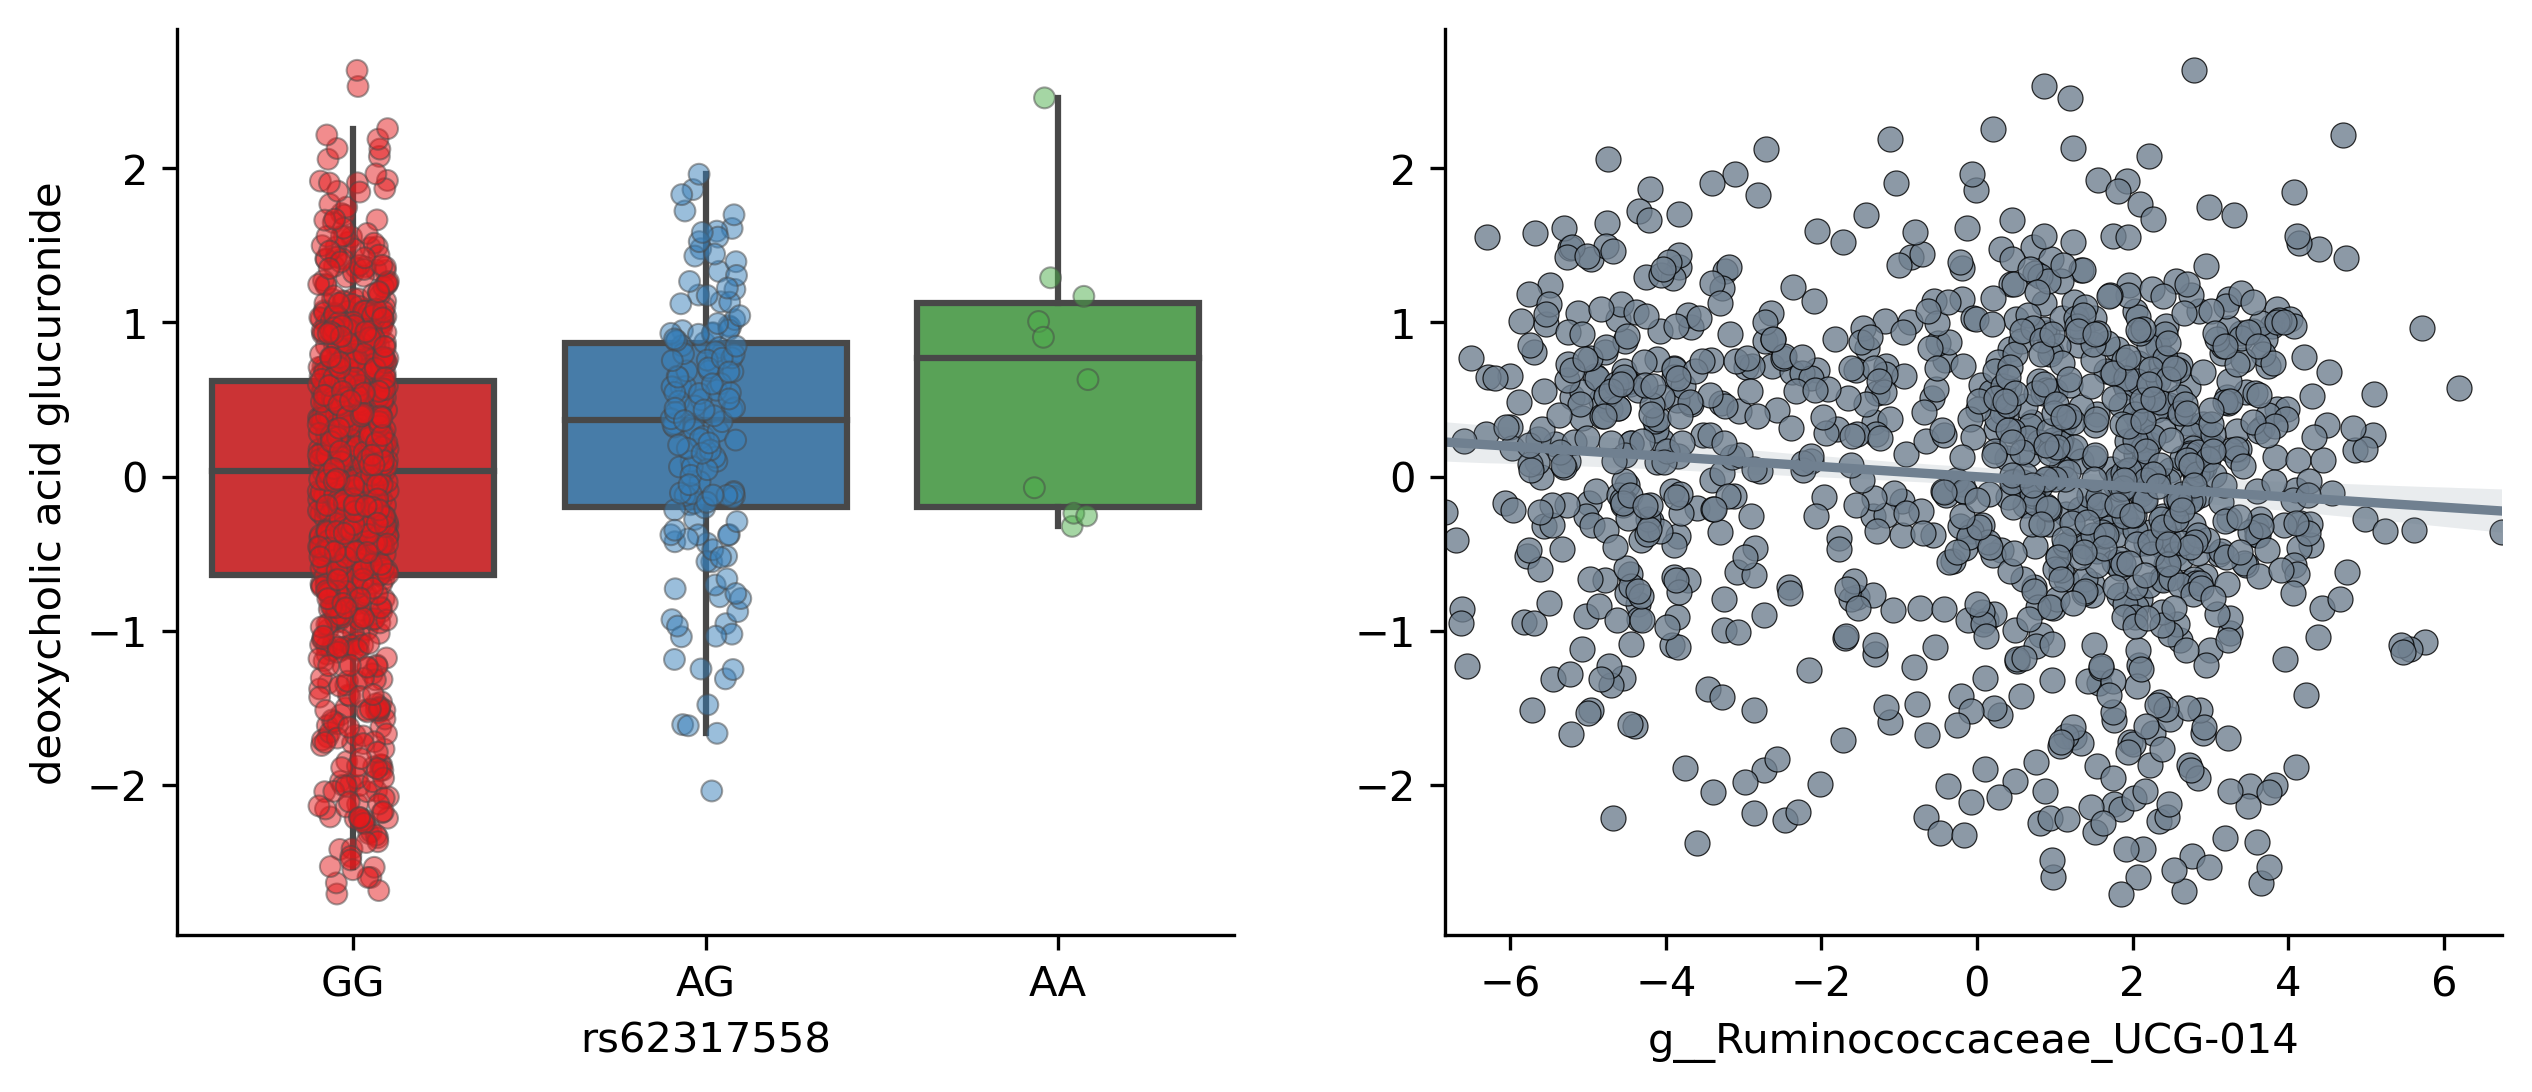

global rho=-0.103723, p=0.000651589
AA: rho=0.1983, p=0.582878
AG: rho=-0.184944, p=0.0216621
GG: rho=-0.0974396, p=0.0032066


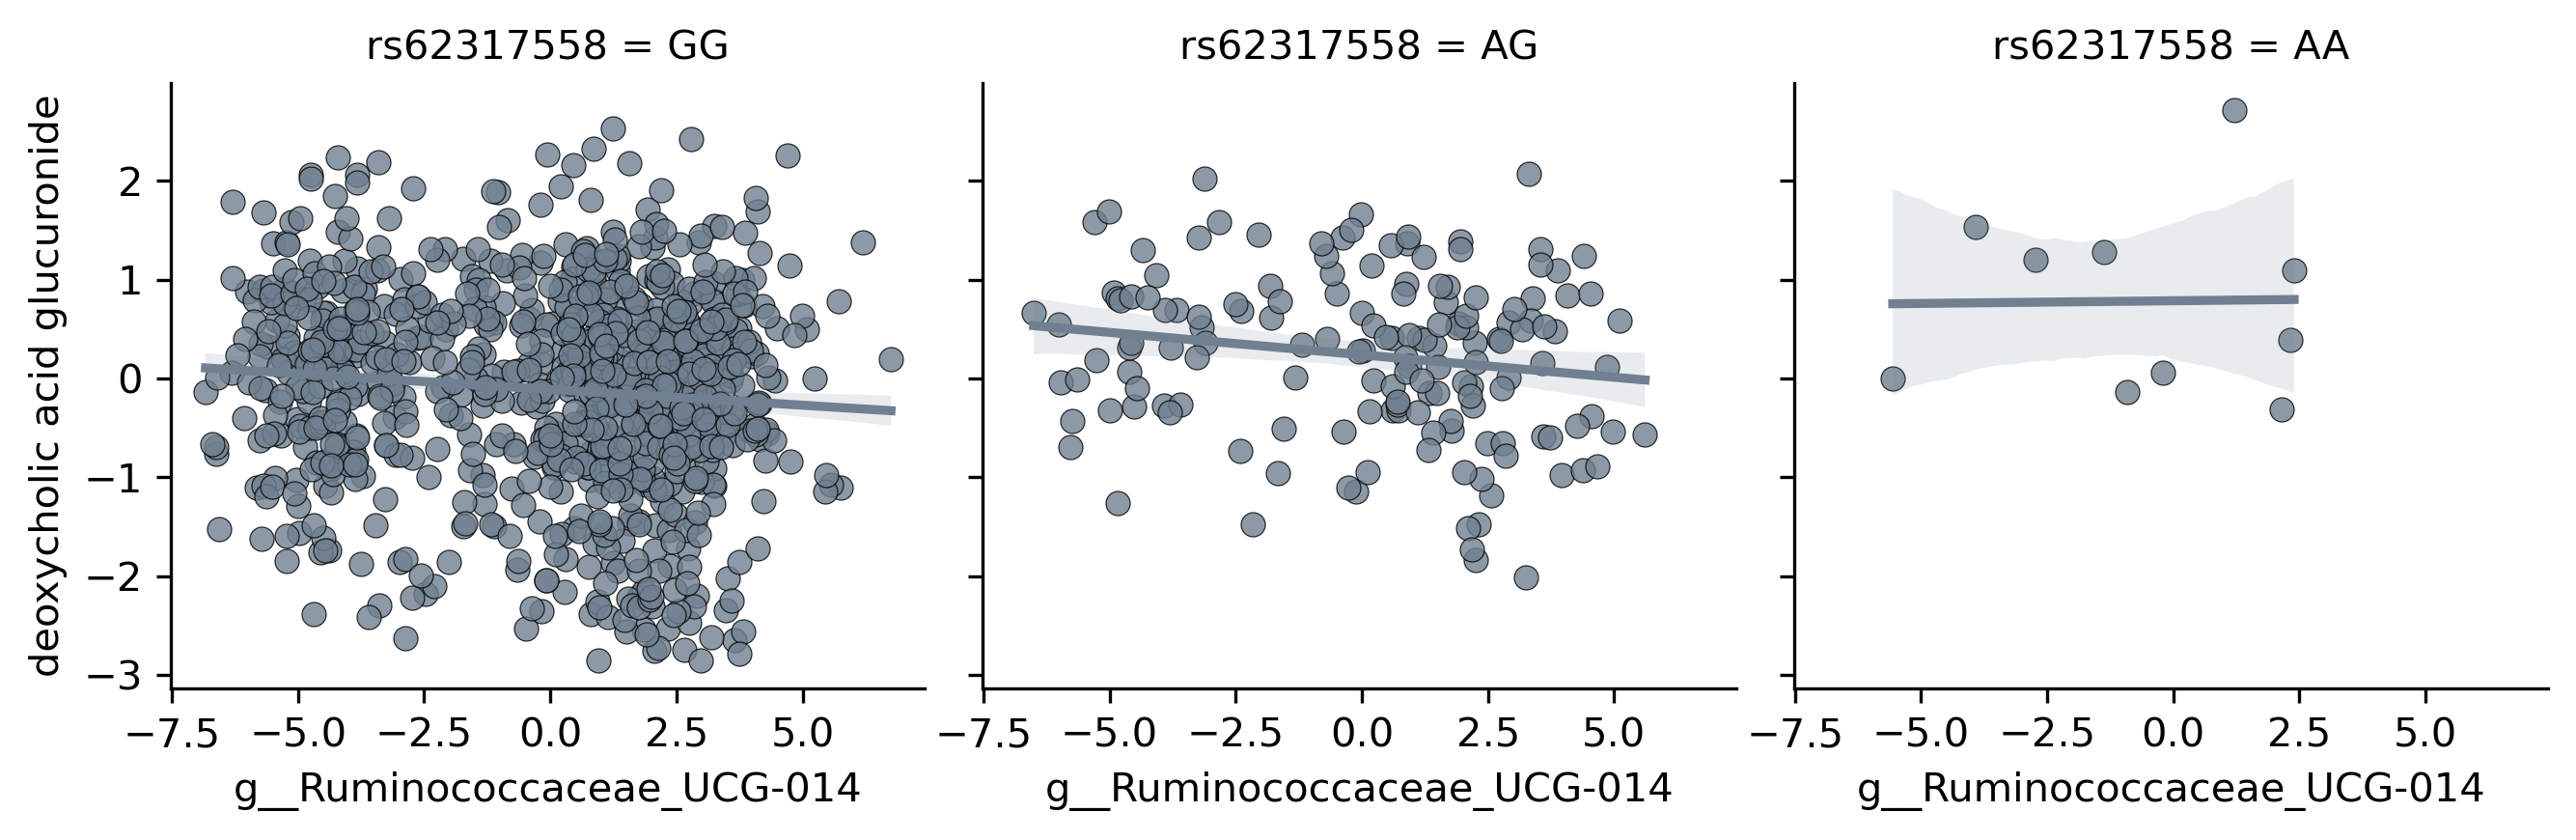

rs62317558 deoxycholic acid glucuronide g__Ruminococcaceae_UCG-014


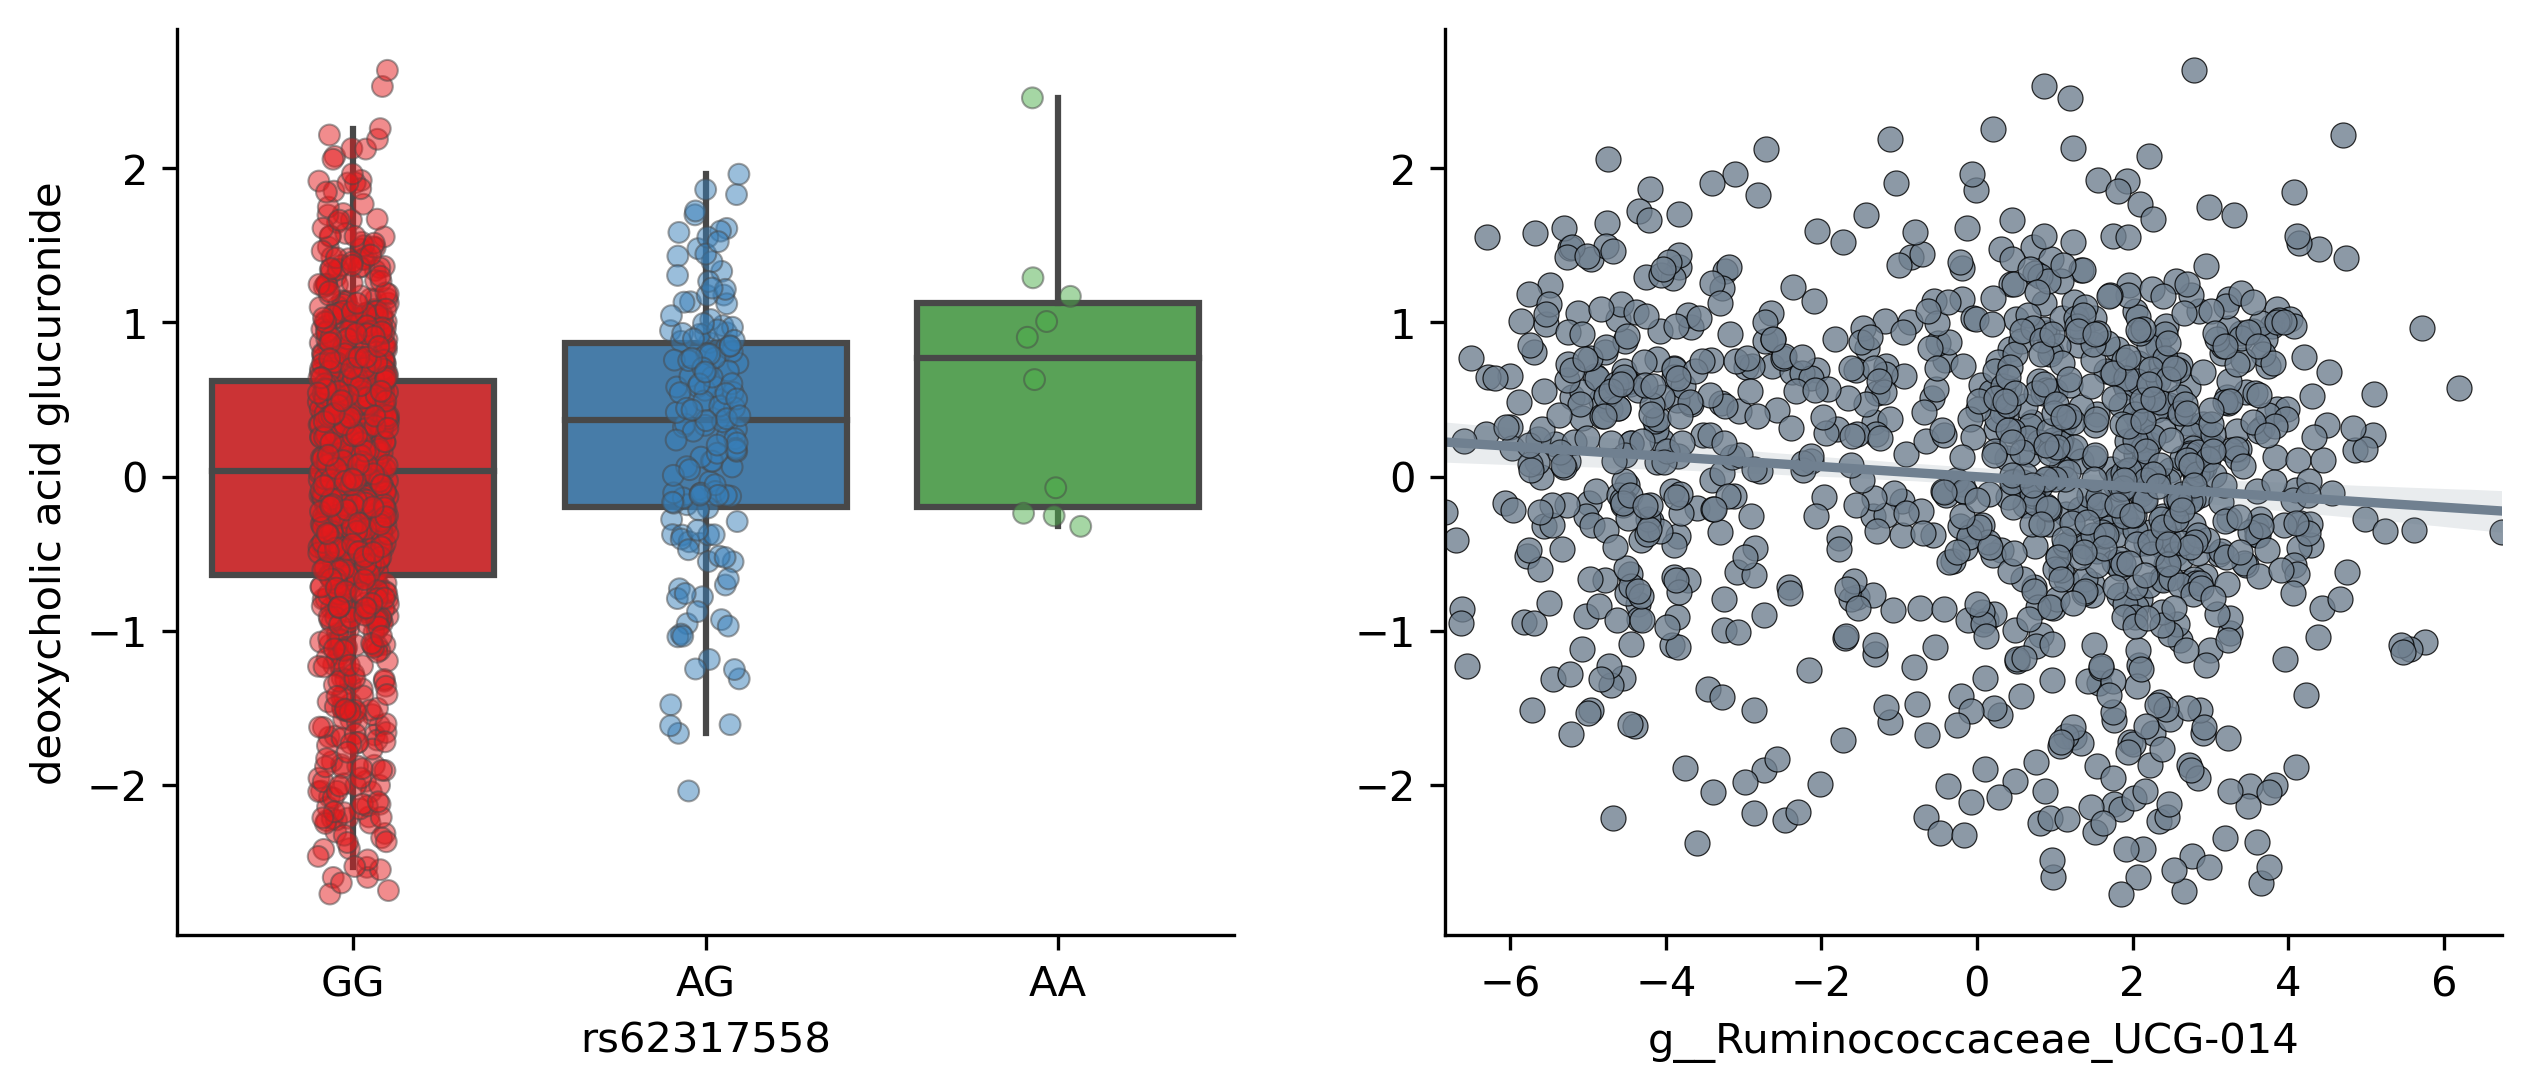

global rho=-0.103723, p=0.000651589
AA: rho=0.1983, p=0.582878
AG: rho=-0.184944, p=0.0216621
GG: rho=-0.0974396, p=0.0032066


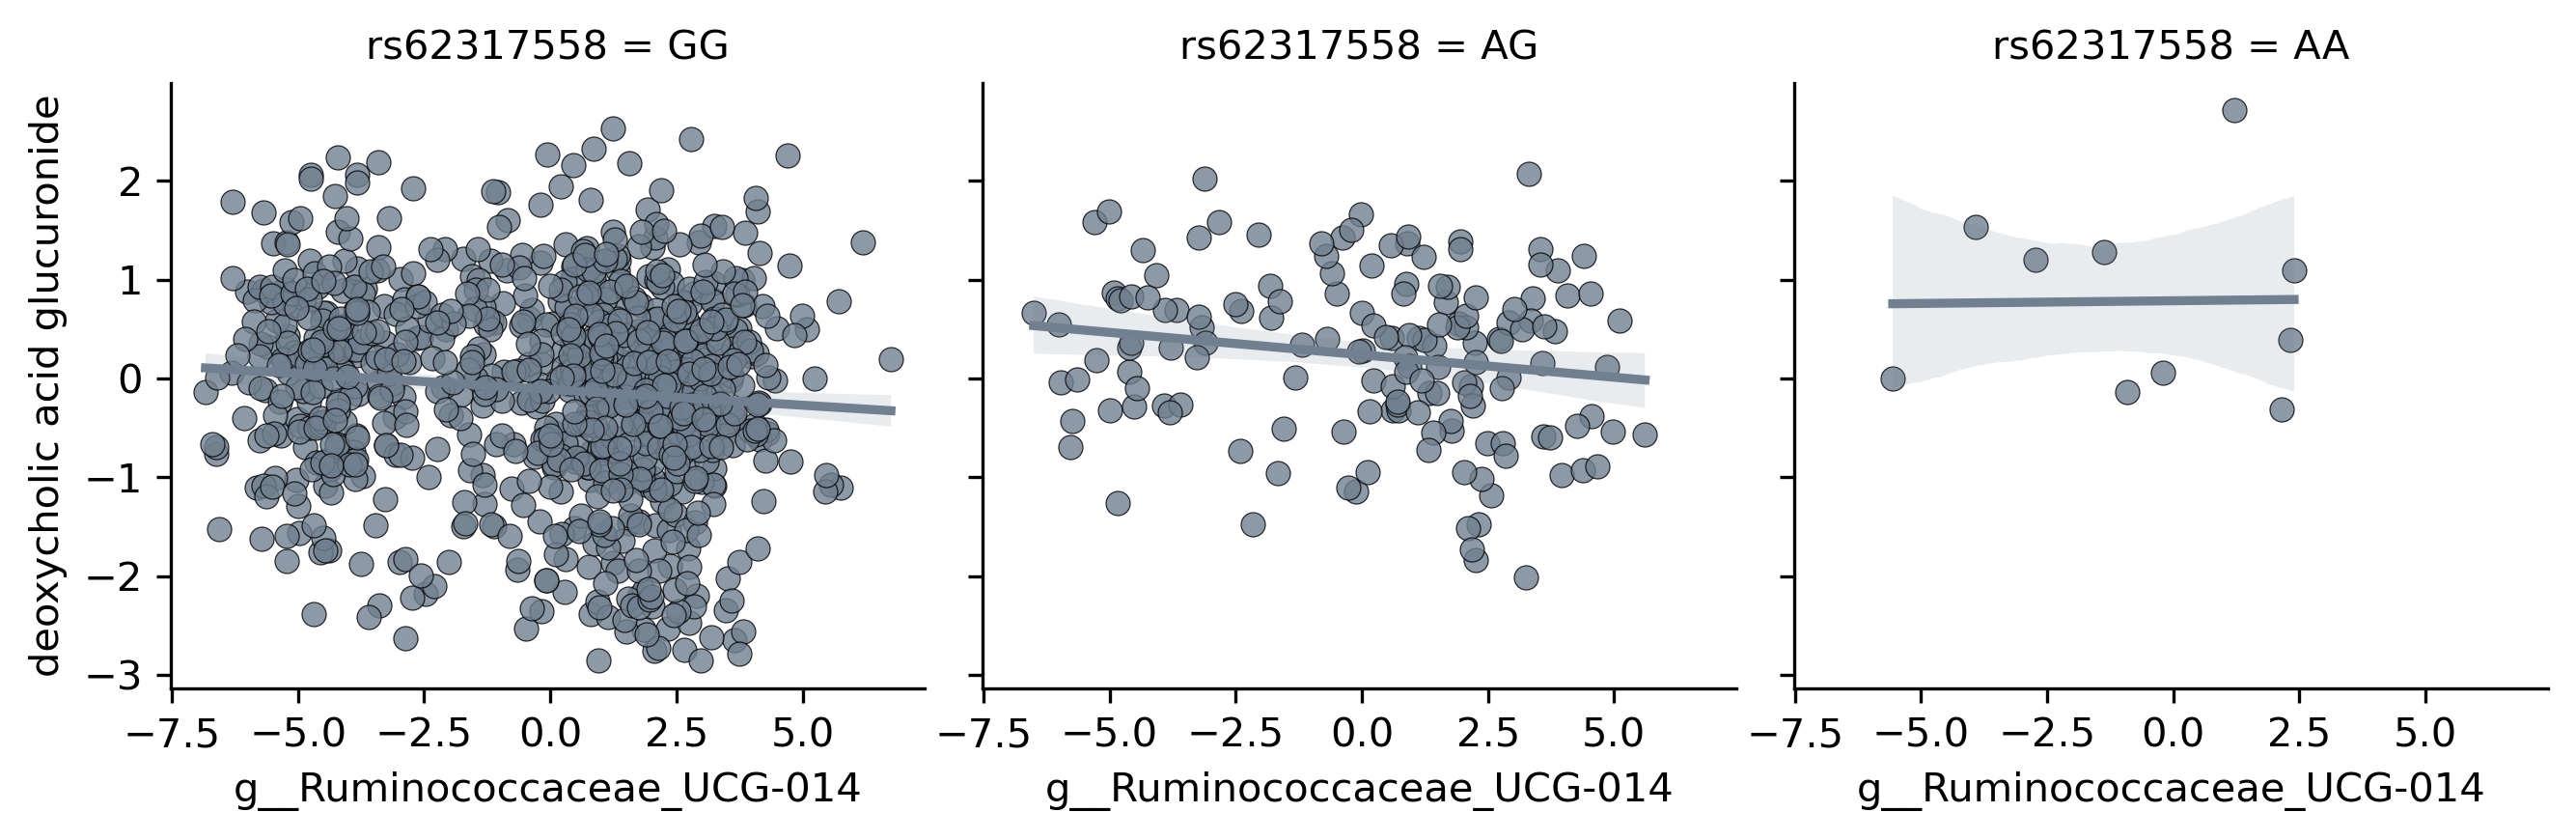

rs62317558 deoxycholic acid glucuronide g__Ruminococcaceae_UCG-014


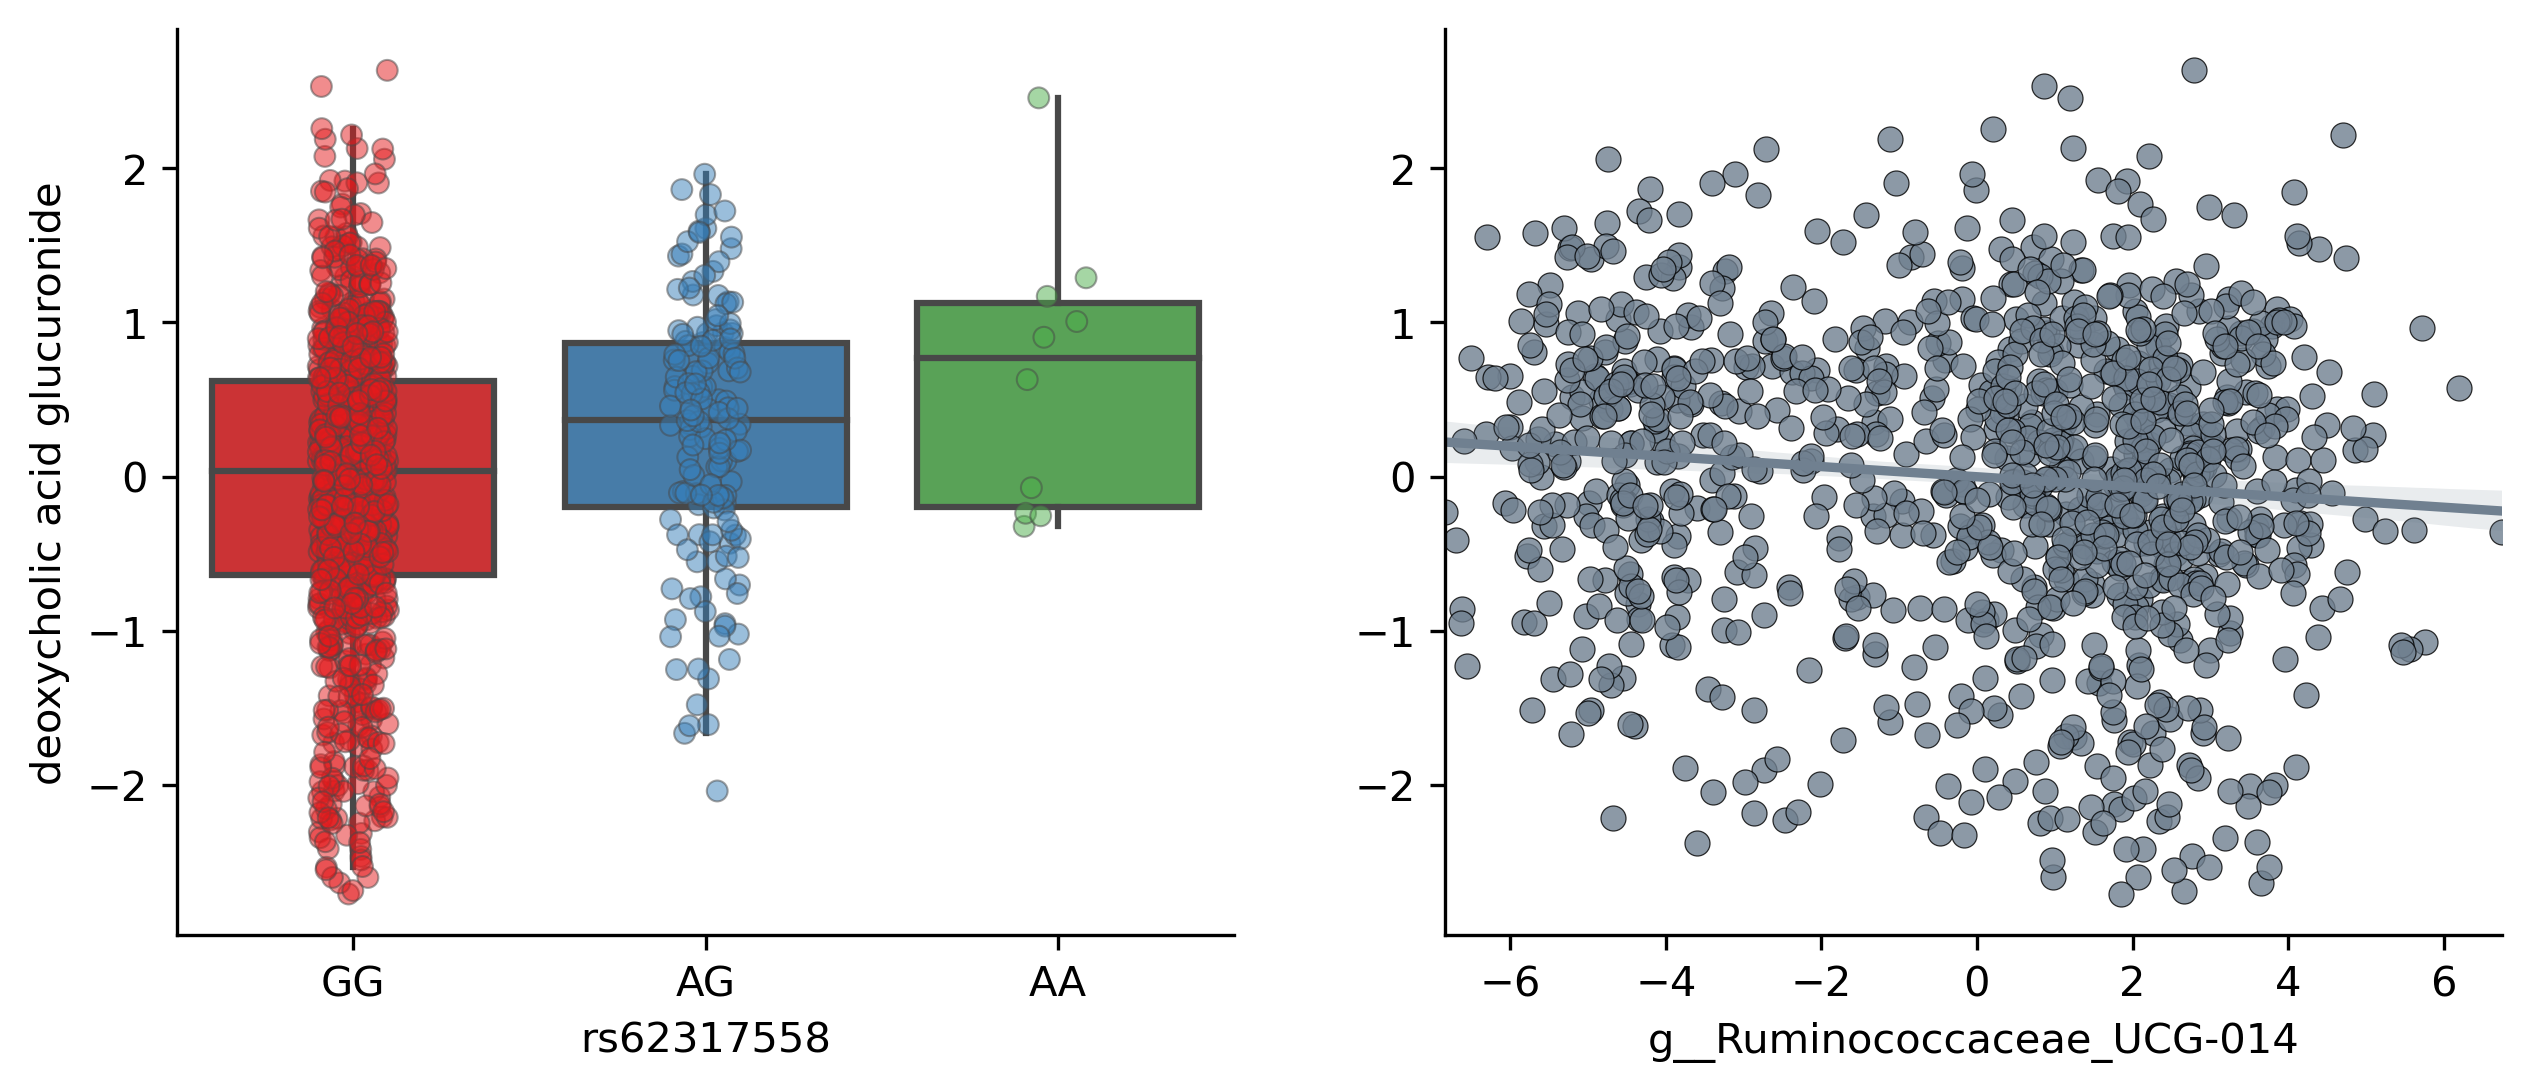

global rho=-0.103723, p=0.000651589
AA: rho=0.1983, p=0.582878
AG: rho=-0.184944, p=0.0216621
GG: rho=-0.0974396, p=0.0032066


In [ ]:
for i in temp_gxe_interest.index[0:5]:
    hit = pd.Series({"metabolite_id": "X100020550", "rsid": "rs62317558", "tax_id": "X2612aa496c0c893a37fa49cb16e7cdb8_genus"})
    sig_metab = hit['metabolite_id']
    sig_rsid = hit['rsid']
    sig_microbe = hit['tax_id']
    temp_hit_geno = pandas.DataFrame(genotype.get_acgt_geno_marker(sig_rsid), index = sample_ids, columns = [sig_rsid])
    temp_hit_geno = temp_hit_geno.join(pandas.DataFrame(genotype.get_geno_marker(sig_rsid), index = sample_ids, columns = [sig_rsid + '_alt_count']))
    temp_pheno_covar_merged = pheno_covar_merged[[sig_metab, sig_microbe] + covariates].join(temp_hit_geno, how = 'inner').dropna()

    bim = genotype.get_bim()
    hit_minor_allele = bim.loc[sig_rsid, 'a1']
    hit_major_allele = bim.loc[sig_rsid, 'a2']
    allele_order = [hit_major_allele*2, hit_minor_allele + hit_major_allele, hit_minor_allele*2]

    temp_cov_adj_formula = sig_metab + ' ~ ' + ' + '.join(form_covar + rename_c_covar)
    temp_cov_adj_lm = ols(temp_cov_adj_formula, temp_pheno_covar_merged).fit()
    temp_pheno_covar_merged['covar_adj'] = temp_cov_adj_lm.resid

    print(sig_rsid, metabolite_metadata_dict[sig_metab], genus_metadata_dict[sig_microbe])

    scatter_args = {'linewidth':0.3, 'edgecolor':'black', 'color':'slategrey'}
    line_args = {'color':'slategrey'}
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize = (10,4), sharey= False)
    sns.boxplot(x = sig_rsid, y= 'covar_adj', data = temp_pheno_covar_merged, 
                order = allele_order, ax = ax1, palette = 'Set1', showfliers = False, showcaps = False)
    sns.stripplot(x = sig_rsid, y= 'covar_adj', data = temp_pheno_covar_merged, 
                  order = allele_order, ax = ax1, palette = 'Set1', linewidth=0.5, alpha = 0.5)
    sns.regplot(x = sig_microbe, y = 'covar_adj', data = temp_pheno_covar_merged,
                scatter_kws = scatter_args, ax = ax2,
               line_kws = line_args)
    ax1.set_ylabel(metabolite_metadata_dict[sig_metab])
    ax2.set_ylabel('')
    ax2.set_xlabel(genus_metadata_dict[sig_microbe])
    sns.despine()
    #plt.savefig(f"figures/{sig_metab}|{sig_microbe}|{sig_rsid}_basic.png", dpi=300, width=6, height=4, bbox_inches="tight")
    plt.show()
    plt.close()
    
    print("global rho=%g, p=%g" % scipy.stats.pearsonr(temp_pheno_covar_merged['covar_adj'], temp_pheno_covar_merged[sig_microbe]))
    for index, (protein_genotype, subset_df) in enumerate(temp_pheno_covar_merged.groupby(sig_rsid)):
        slope, intercept, r, pval, std = scipy.stats.linregress(subset_df['covar_adj'], subset_df[sig_microbe])
        print("%s: rho=%g, p=%g" % (protein_genotype, r, pval))
    
    g = sns.FacetGrid(data=temp_pheno_covar_merged, col=sig_rsid, col_order = allele_order)
    g.map(sns.regplot, sig_microbe, sig_metab,  scatter_kws = scatter_args, line_kws = line_args)
    g.set(xlim=(temp_pheno_covar_merged[sig_microbe].min()*1.1, temp_pheno_covar_merged[sig_microbe].max()*1.1),
         ylim=(temp_pheno_covar_merged[sig_metab].min()*1.1, temp_pheno_covar_merged[sig_metab].max()*1.1))
    g.set_xlabels(genus_metadata_dict[sig_microbe])
    g.set_ylabels(metabolite_metadata_dict[sig_metab])
    #plt.savefig(f"figures/{sig_metab}|{sig_microbe}|{sig_rsid}_groups.png", dpi=300, width=6, height=4, bbox_inches="tight")
    plt.show()
    plt.close()

In [ ]:
temp_pheno_covar_merged['affected'] = [1 if i.count(hit_minor_allele) > 0 
                                       else 0 
                                       for i in temp_pheno_covar_merged[sig_rsid]]
affected_order = [0, 1]
affected_x_tick_label = list(map({0:'unaffected', 1:'affected'}.get, affected_order))

print(ols('{0} ~ {1}'.format(sig_microbe,'affected'), data=temp_pheno_covar_merged).fit().pvalues['affected'])
print(ols('{0} ~ {1}'.format(sig_microbe,sig_rsid+'_alt_count'), data=temp_pheno_covar_merged).fit().pvalues[sig_rsid+'_alt_count'])


fig, ax = plt.subplots()
sns.boxplot(x = 'affected', y= sig_microbe, data = temp_pheno_covar_merged, order = [0, 1], ax = ax, palette = 'Set1')
sns.stripplot(x = 'affected', y= sig_microbe, data = temp_pheno_covar_merged, order = [0, 1], ax = ax, palette = 'Set1', linewidth=0.5)
ax.set_xticklabels(affected_x_tick_label)
ax.set_xlabel('')
ax.set_ylabel(genus_metadata_dict[sig_microbe])
plt.show()
plt.close()

In [ ]:
gxe_fold_results_annotated.shape

In [ ]:
(temp_gxe_interest.gxe_rsq - temp_gxe_interest.baseline_rsq).astype(float).describe()

In [ ]:
from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests

def stars(p):
    if p>0.05:
        return "n.s."
    else:
        return sum(p < c for c in [0.05, 0.01, 0.001]) * "٭"

def enrichment(full_data, sig_data, column, figsize=(3, 4), min_sig=1):
    full_counts = full_data[column].value_counts()
    sig_counts = sig_data[column].value_counts()
    stats = pd.DataFrame({"full_counts": full_counts, "sig_counts": sig_counts, "n": full_counts.sum(), "sig_n": sig_counts.sum()}).fillna(0)
    stats["p"] = stats.apply(lambda df: hypergeom.sf(max(0, df.sig_counts - 1), df.n, max(df.full_counts, 1), df.sig_n), axis=1)
    stats["odds"] = (stats.sig_counts / stats.sig_n) / (stats.full_counts / stats.n)
    stats["log_odds"] = np.log(stats.odds)
    stats["q"] = multipletests(stats.p, method="fdr_bh")[1]
    
    stats["all"] = stats["full_counts"] / stats["n"]
    stats["significant"] = stats["sig_counts"] / stats["sig_n"]
    stats.index.name = column
    stats.reset_index(inplace=True)
    
    long = stats[stats.sig_counts >= min_sig].melt(id_vars=[column, "p", "q"], value_vars=["all", "significant"], value_name="prevalence", var_name="group")
    long[column] = pd.Categorical(long[column], long.sort_values(by="prevalence")[column].unique()) 
    long["sig_stars"] = long.q.apply(stars)
    
    pl = (
        ggplot(long, aes(x="prevalence", y=column, shape="group", color="group")) +
        geom_line(aes(group=column), color="black") +
        geom_point(size=2) +
        theme_minimal() +
        theme(figure_size=figsize) +
        labs(y="")
    )
    if (long.q < 0.05).any():
        pl += geom_text(
            aes(label="sig_stars"), 
            data=long[(long.q<0.05) & (long.group == "significant")], 
            color="black", va="center", ha="left", 
            nudge_x=(long.prevalence.max() - long.prevalence.min())*0.025)
    
    return stats.sort_values(by="p"), pl

In [ ]:
pathway_enr = enrichment(gxe_fold_results_annotated, sig_gxe_fold_results_annotated, "sub_pathway", figsize=(3, 5))
microbe_enr = enrichment(gxe_fold_results_annotated, sig_gxe_fold_results_annotated, "family", figsize=(3, 4))
gene_enr = enrichment(gxe_fold_results_annotated, sig_gxe_fold_results_annotated, "gene_symbol", figsize=(3, 7))

In [ ]:
pathway_enr[1].save("figures/enriched_pathways.pdf", width=3, height=5)
pathway_enr[1]

In [ ]:
microbe_enr[1].save("figures/enriched_microbes.pdf", width=3, height=4)
microbe_enr[1]

In [ ]:
gene_enr[1].save("figures/enriched_genes.pdf", width=3, height=7)
gene_enr[1]

In [ ]:
snp_enr[0]